In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [2]:
X_train_pca = pd.read_csv("datasets/X_train_pca.csv")
X_test_pca = pd.read_csv("datasets/X_test_pca.csv")
y_train = pd.read_csv("datasets/y_train.csv")
y_test = pd.read_csv("datasets/y_test.csv")

In [3]:
X_train_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
0,-10.132157,2.139075,-0.248008,1.028276,-0.584810,0.302597,0.313558,-0.461281,-0.449092,0.040297,...,0.011108,0.017903,-0.049671,-0.032263,-0.104740,0.005738,0.021138,-0.022800,-0.025010,0.040547
1,7.921871,-5.960722,3.058930,-0.026734,3.767385,-0.275739,1.606370,-0.452295,1.096728,-1.371964,...,0.047207,-0.419713,0.027002,0.280632,0.202550,0.123870,0.379266,0.204190,-0.009580,0.844153
2,3.680115,-9.871570,-0.242352,-0.026592,0.692070,0.661598,-0.516094,1.267696,1.431083,0.604950,...,0.103591,0.184320,0.022717,-0.329293,0.202482,0.307484,0.051162,0.344723,0.035394,-0.365325
3,-11.923587,2.045905,0.141644,0.201153,-0.413577,0.740162,0.339979,-0.410190,-0.447011,-0.430531,...,0.027129,0.005678,-0.025135,0.006754,0.019937,0.066130,-0.007596,0.007389,0.017305,-0.048783
4,26.493567,1.883936,-2.087893,0.425285,-3.415314,1.063025,-3.635968,-3.579289,0.007682,0.494845,...,0.036545,-0.050285,-0.076398,-0.534919,0.145815,-0.215346,0.112721,0.145093,-0.182020,0.140224


#### Elbow Method
The Elbow method is a visual method that involves plotting the explained variance as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use. This method is based on the principle that as you increase the number of clusters, the within-cluster **Sum of Squares (WCSS)** will decrease because the clusters are smaller. The goal is to choose a small value of k that still has a low WCSS, and the elbow usually represents where the rate of decrease sharply changes. This can be seen as a point in the graph where adding another cluster doesn't give much better modeling of the data.

Here's how we will apply the Elbow method:

1. Compute k-means clustering for different values of k (for example, k from 1 to 10).
2. For each k, calculate the total within-cluster sum of square (WCSS).
3. Plot the curve of WCSS against the number of clusters k.
4. The location of a bend (elbow) in the plot is generally considered as an indicator of the appropriate number of clusters.

### WCSS (Within-Cluster Sum of Squares):
WCSS is the sum of squared distances between each point within a cluster and the centroid of that cluster. It is a measure of the variance within each cluster. When you plot WCSS against the number of clusters (k), the point where the rate of decrease sharply changes (the "elbow") is often considered a good indication of the number of clusters. A lower WCSS indicates that the clusters are tighter, which is generally better for k-means clustering.

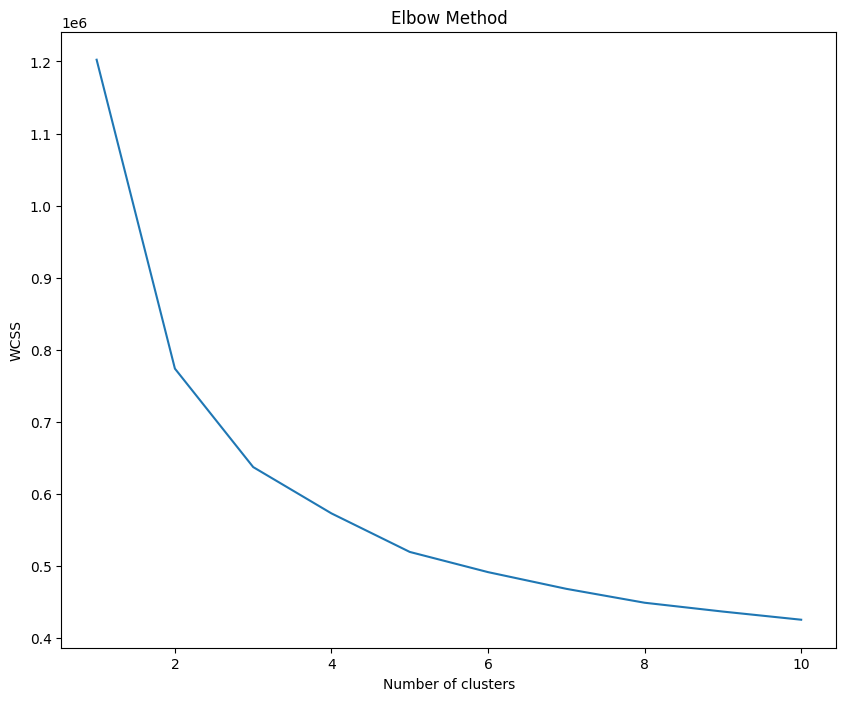

In [4]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_train_pca)
    # The "kmeans.inertia_" method returns the WCSS for the model, 
    # which quantifies how close the data points are to their respective centroids.
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,8))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') # within cluster sum of squares
plt.show()

The **silhouette value** is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

In [5]:
# Define a custom scorer that computes the silhouette score
def silhouette_scorer(estimator, X):
    cluster_labels = estimator.fit_predict(X)
    score = silhouette_score(X, cluster_labels)
    return score

# Parameter grid for GridSearchCV
param_grid = {'n_clusters': list(range(2, 11))}

# Initialize GridSearchCV with the k-means model and the silhouette scorer
grid_search = GridSearchCV(KMeans(init='k-means++', max_iter=300, n_init=10, random_state=0),
                           param_grid, scoring=silhouette_scorer, cv=5)

# Fit the GridSearchCV to the data
grid_search.fit(X_train_pca)

# The best number of clusters (k)
best_k = grid_search.best_params_['n_clusters']
print(f"The best number of clusters according to GridSearchCV is: {best_k}")

The best number of clusters according to GridSearchCV is: 2


In [6]:
y_train.values.ravel().shape

(7752,)

In [7]:
X_train_pca.shape

(7752, 130)

In [8]:
y_train.shape

(7752, 1)

In [9]:
y_test.shape

(1938, 1)

### Adjusted Rand Index (ARI)

The Adjusted Rand Index (ARI) is a measure of similarity between two data clusterings. Given the ground truth cluster assignments and the clustering produced by an algorithm, ARI scores how similar the assignments are, adjusting for chance. It's a value that ranges from -1 to 1. A score close to 1 indicates that the two clusterings are in substantial agreement, a score close to 0 indicates random labeling, and a score close to -1 indicates inverse agreement.

- **Advantages**:
  - ARI has the upper bound of 1, and is symmetric: switching label_true with label_pred will not change the score. This is not true for metrics like mutual information.
  - ARI considers all pairs of samples and counts pairs that are assigned in the same or different clusters in the predicted and true clusterings.

- **Interpretation**:
  - ARI = 1: The clustering is a perfect match with the true labels.
  - ARI < 1: The clustering is imperfect, with the number indicating the degree of match.
  - ARI = 0: The clustering is no better than a random assignment.
  - ARI < 0: The clustering is worse than random.

/Users/ilya/mainvenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ilya/mainvenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ilya/mainvenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ilya/mainvenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ilya/mainvenv/lib/pyt

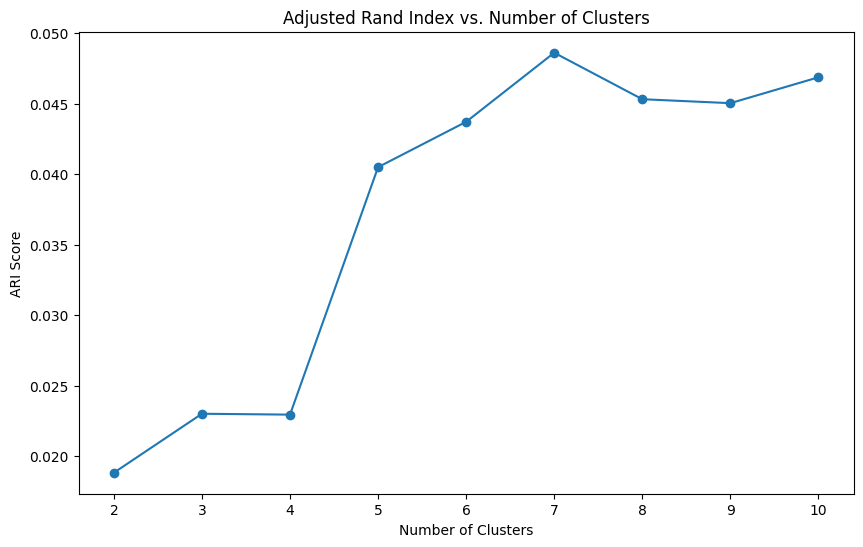

In [10]:
from sklearn.metrics import adjusted_rand_score

# Range of clusters to evaluate
range_n_clusters = list(range(2, 11))  # example range from 2 to 10 clusters

ari_scores = []

for n_clusters in range_n_clusters:
    # Initialize the KMeans with the current number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    
    # Fit and predict the data to get the clusters
    cluster_labels = kmeans.fit_predict(X_train_pca)
    
    # Calculate the ARI score
    ari = adjusted_rand_score(y_train.values.ravel(), cluster_labels)
    ari_scores.append(ari)

# Plotting the ARI score for different numbers of clusters
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, ari_scores, marker='o')
plt.title('Adjusted Rand Index vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('ARI Score')
plt.show()

/Users/ilya/mainvenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


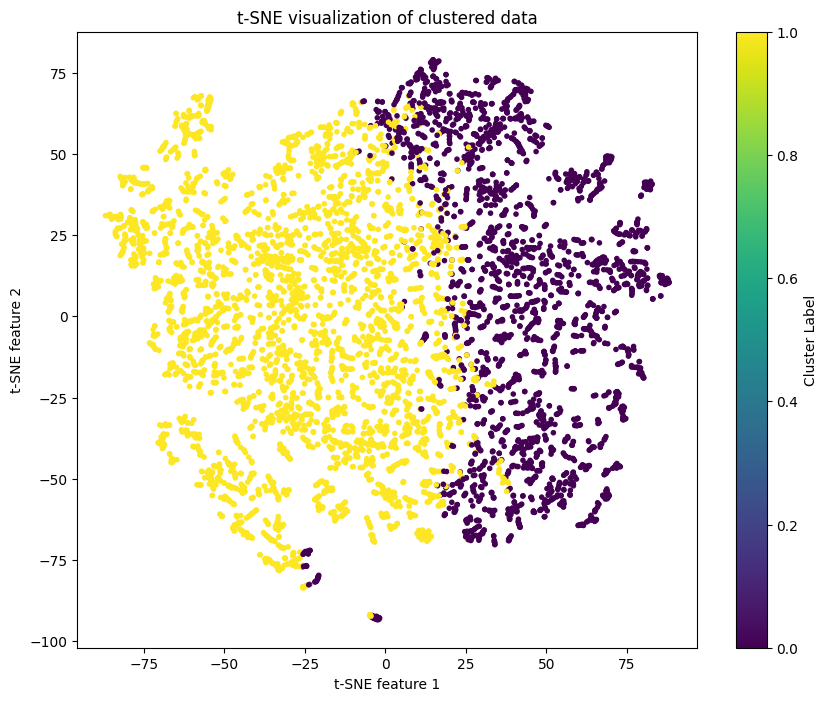

In [11]:
# Choosing the best n_clusters
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X_train_pca)

# Perform t-SNE embedding
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_pca)

# Plot t-SNE
plt.figure(figsize=(10, 8))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=cluster_labels, cmap='viridis', marker='.')
plt.title('t-SNE visualization of clustered data')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

/Users/ilya/mainvenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ilya/mainvenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ilya/mainvenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ilya/mainvenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ilya/mainvenv/lib/pyt

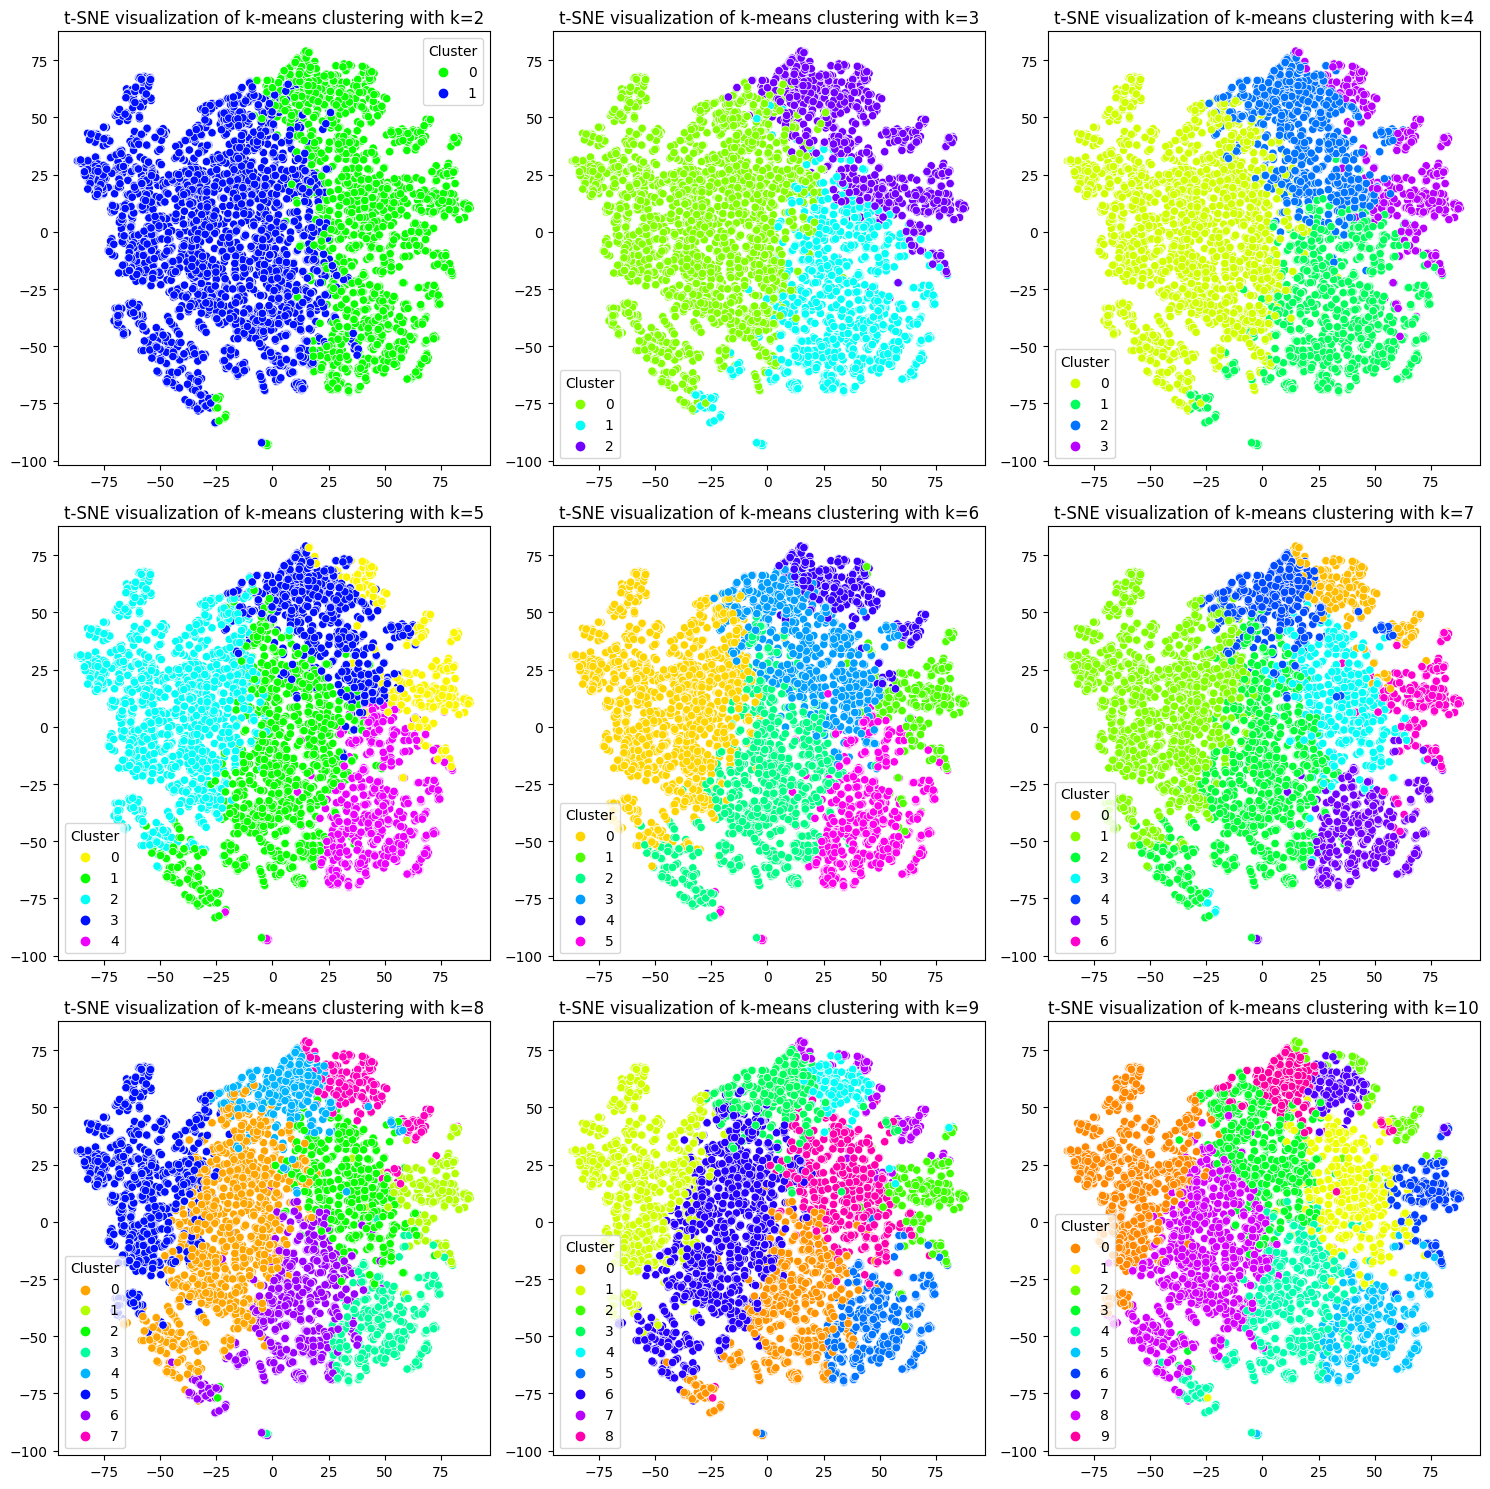

In [12]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Number of clusters to try
cluster_options = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Set up the matplotlib figure
n_rows = len(cluster_options) // 3 + (len(cluster_options) % 3 > 0)
fig, axes = plt.subplots(n_rows, 3, figsize=(15, n_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop over the different values of k
for i, k in enumerate(cluster_options):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X_train_pca)

    # Run t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    X_reduced_tsne = tsne.fit_transform(X_train_pca)

    # Plot t-SNE
    sns.scatterplot(x=X_reduced_tsne[:, 0], y=X_reduced_tsne[:, 1], hue=clusters, palette=sns.color_palette("hsv", k), ax=axes[i])
    axes[i].set_title(f't-SNE visualization of k-means clustering with k={k}')
    axes[i].legend(title='Cluster')

# Remove any extra subplots
for j in range(i+1, n_rows * 3):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()